In [1]:
import numpy as np #matrix math
import tensorflow as tf #machine learning
import matplotlib.pyplot as plt #plotting
%matplotlib inline

# Import MINST data
#The MNIST data is split into three parts: 55,000 data points of training data 
#10,000 points of test data and 5,000 points of validation data 
#very MNIST data point has two parts: an image of a handwritten digit 
#and a corresponding label. 
#We'll call the images "x" and the labels "y". 
#Both the training set and test set contain images and their corresponding labels; 
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from t

In [2]:
#Each image is 28 pixels by 28 pixels. We can interpret this as a big array of numbers:
n_pixels = 28*28
# Input to the graph -- Tensorflow's MNIST images are (1, 784) vectors
#x isn’t a specific value. 
#It’s a placeholder, a value that we’ll input when we ask TensorFlow 
#to run a computation. We want to be able to input any number of MNIST images, 
#each flattened into a 784-dimensional vector. We represent this as a 2-D tensor of 
#floating-point numbers
X = tf.placeholder(tf.float32, shape=([None, n_pixels]))

In [3]:

#layer creation functions
#we could do this inline but cleaner to wrap it in respective functions

#represent the strength of connections between units.
def weight_variable(shape, name):
    #Outputs random values from a truncated normal distribution.
    #truncated means the value is either bounded below or above (or both)
    initial = tf.truncated_normal(shape, stddev=0.1)
    #A Variable is a modifiable tensor that lives in TensorFlow’s graph of 
    #interacting operations. It can be used and even modified by the computation. 
    #For machine learning applications, one generally has the model parameters 
    #be Variables.
    return tf.Variable(initial, name=name)

#Bias nodes are added to increase the flexibility of 
#the model to fit the data. Specifically, it allows the 
#network to fit the data when all input features are equal to 00, 
#and very likely decreases the bias of the fitted values elsewhere in the data space
def bias_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

#Neurons in a fully connected layer have full connections to 
#all activations in the previous layer, as seen in regular Neural Networks. 
#Their activations can hence be computed with a matrix multiplication followed by a 
#bias offset. 
def FC_layer(X, W, b):
    return tf.matmul(X, W) + b

In [6]:
# encoder
#our VAE model can parse the information spread thinly over the high-dimensional 
#observed world of pixels, and condense the most meaningful features into a 
#structured distribution over reduced (20) latent dimensions
#latent = embedded space, we just see latent used in stochastic models in papers a lot
#latent means not directly observed but are rather inferred
latent_dim = 20
#num neurons
h_dim = 500

#layer 1
W_enc = weight_variable([n_pixels, h_dim], 'W_enc')
b_enc = bias_variable([h_dim], 'b_enc')
# tanh activation function to replicate original model
#The tanh function, a.k.a. hyperbolic tangent function, 
#is a rescaling of the logistic sigmoid, such that its outputs range from -1 to 1.
#tanh or sigmoid? Whatever avoids the vanishing gradient problem!
h_enc = tf.nn.tanh(FC_layer(X, W_enc, b_enc))

#layer 2
W_mu = weight_variable([h_dim, latent_dim], 'W_mu')
b_mu = bias_variable([latent_dim], 'b_mu')
mu = FC_layer(h_enc, W_mu, b_mu) #mean

#instead of the encoder generating a vector of real values, 
#it will generate a vector of means and a vector of standard deviations.
#for reparamterization
W_logstd = weight_variable([h_dim, latent_dim], 'W_logstd')
b_logstd = bias_variable([latent_dim], 'b_logstd')
logstd = FC_layer(h_enc, W_logstd, b_logstd)

# reparameterization trick - lets us backpropagate successfully
#since normally gradient descent expects deterministic nodes
#and we have stochastic nodes
#distribution
noise = tf.random_normal([1, latent_dim])
#sample from the standard deviations (tf.exp computes exponential of x element-wise) 
#and add the mean 
#this is our latent variable we will pass to the decoder
z = mu + tf.multiply(noise, tf.exp(.5*logstd))
#The greater standard deviation on the noise added, 
#the less information we can pass using that one variable.
#The more efficiently we can encode the original image, 
#the higher we can raise the standard deviation on our gaussian until it reaches one.
#This constraint forces the encoder to be very efficient, 
#creating information-rich latent variables. 
#This improves generalization, so latent variables that we either randomly generated, 
#or we got from encoding non-training images, will produce a nicer result when decoded.

In [7]:

# decoder

#layer 1
W_dec = weight_variable([latent_dim, h_dim], 'W_dec')
b_dec = bias_variable([h_dim], 'b_dec')
#pass in z here (and the weights and biases we just defined)
h_dec = tf.nn.tanh(FC_layer(z, W_dec, b_dec))


#layer 2, using the original n pixels here since thats the dimensiaonlty
#we want to restore our data to
W_reconstruct = weight_variable([h_dim, n_pixels], 'W_reconstruct')
b_reconstruct = bias_variable([n_pixels], 'b_reconstruct')
#784 bernoulli parameters output
reconstruction = tf.nn.sigmoid(FC_layer(h_dec, W_reconstruct, b_reconstruct))

In [8]:
#lets define our loss function

# variational lower bound

# add epsilon to log to prevent numerical overflow
#Information is lost because it goes from a smaller to a larger dimensionality. 
#How much information is lost? We measure this using the reconstruction log-likelihood 
#This measure tells us how effectively the decoder has learned to reconstruct
#an input image x given its latent representation z.
log_likelihood = tf.reduce_sum(X*tf.log(reconstruction + 1e-9)+(1 - X)*tf.log(1 - reconstruction + 1e-9), reduction_indices=1)
#KL Divergence
#If the encoder outputs representations z that are different 
#than those from a standard normal distribution, it will receive 
#a penalty in the loss. This regularizer term means 
#‘keep the representations z of each digit sufficiently diverse’. 
#If we didn’t include the regularizer, the encoder could learn to cheat
#and give each datapoint a representation in a different region of Euclidean space. 
KL_term = -.5*tf.reduce_sum(1 + 2*logstd - tf.pow(mu,2) - tf.exp(2*logstd), reduction_indices=1)

# This allows us to use stochastic gradient descent with respect to the variational parameters
variational_lower_bound = tf.reduce_mean(log_likelihood - KL_term)
optimizer = tf.train.AdadeltaOptimizer().minimize(-variational_lower_bound)

In [9]:
#init all variables and start the session!
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)
## Add ops to save and restore all the variables.
saver = tf.train.Saver()

In [13]:
import time #lets clock training time..

num_iterations = 1000000
recording_interval = 1000
#store value for these 3 terms so we can plot them later
variational_lower_bound_array = []
log_likelihood_array = []
KL_term_array = []
iteration_array = [i*recording_interval for i in range(int(num_iterations/recording_interval))]
for i in range(int(num_iterations)):
    # np.round to make MNIST binary
    #get first batch (200 digits)
    x_batch = np.round(mnist.train.next_batch(200)[0])
    #run our optimizer on our data
    sess.run(optimizer, feed_dict={X: x_batch})
    if (i%recording_interval == 0):
        #every 1K iterations record these values
        vlb_eval = variational_lower_bound.eval(feed_dict={X: x_batch})
        print ("Iteration: {}, Loss: {}".format(i, vlb_eval))
        variational_lower_bound_array.append(vlb_eval)
        log_likelihood_array.append(np.mean(log_likelihood.eval(feed_dict={X: x_batch})))
        KL_term_array.append(np.mean(KL_term.eval(feed_dict={X: x_batch})))

Iteration: 0, Loss: -945.5842895507812
Iteration: 1000, Loss: -745.0390014648438
Iteration: 2000, Loss: -683.9057006835938
Iteration: 3000, Loss: -637.0036010742188
Iteration: 4000, Loss: -631.6213989257812
Iteration: 5000, Loss: -606.419677734375
Iteration: 6000, Loss: -582.05615234375
Iteration: 7000, Loss: -567.9654541015625
Iteration: 8000, Loss: -566.417236328125
Iteration: 9000, Loss: -566.8139038085938
Iteration: 10000, Loss: -545.009033203125
Iteration: 11000, Loss: -519.2413940429688
Iteration: 12000, Loss: -502.3383483886719
Iteration: 13000, Loss: -494.1772155761719
Iteration: 14000, Loss: -472.7458190917969
Iteration: 15000, Loss: -440.2264709472656
Iteration: 16000, Loss: -422.40118408203125
Iteration: 17000, Loss: -398.0128479003906
Iteration: 18000, Loss: -380.2716064453125
Iteration: 19000, Loss: -376.26239013671875
Iteration: 20000, Loss: -368.1070251464844
Iteration: 21000, Loss: -370.57550048828125
Iteration: 22000, Loss: -327.7001037597656
Iteration: 23000, Loss: -3

Iteration: 187000, Loss: -183.64076232910156
Iteration: 188000, Loss: -184.12576293945312
Iteration: 189000, Loss: -192.5992431640625
Iteration: 190000, Loss: -179.12380981445312
Iteration: 191000, Loss: -189.92906188964844
Iteration: 192000, Loss: -185.83578491210938
Iteration: 193000, Loss: -189.47874450683594
Iteration: 194000, Loss: -182.3520965576172
Iteration: 195000, Loss: -179.59898376464844
Iteration: 196000, Loss: -187.53057861328125
Iteration: 197000, Loss: -180.5150604248047
Iteration: 198000, Loss: -179.33078002929688
Iteration: 199000, Loss: -189.89022827148438
Iteration: 200000, Loss: -178.54129028320312
Iteration: 201000, Loss: -180.59547424316406
Iteration: 202000, Loss: -177.94082641601562
Iteration: 203000, Loss: -195.89564514160156
Iteration: 204000, Loss: -189.57440185546875
Iteration: 205000, Loss: -178.92381286621094
Iteration: 206000, Loss: -186.2530059814453
Iteration: 207000, Loss: -175.40371704101562
Iteration: 208000, Loss: -193.95191955566406
Iteration: 209

Iteration: 372000, Loss: -164.08038330078125
Iteration: 373000, Loss: -170.53494262695312
Iteration: 374000, Loss: -164.44692993164062
Iteration: 375000, Loss: -160.17628479003906
Iteration: 376000, Loss: -163.52859497070312
Iteration: 377000, Loss: -169.7367706298828
Iteration: 378000, Loss: -171.10414123535156
Iteration: 379000, Loss: -167.1591033935547
Iteration: 380000, Loss: -159.13050842285156
Iteration: 381000, Loss: -164.55136108398438
Iteration: 382000, Loss: -166.1573486328125
Iteration: 383000, Loss: -163.83233642578125
Iteration: 384000, Loss: -167.22015380859375
Iteration: 385000, Loss: -163.62722778320312
Iteration: 386000, Loss: -163.17733764648438
Iteration: 387000, Loss: -166.02879333496094
Iteration: 388000, Loss: -174.72483825683594
Iteration: 389000, Loss: -170.3829345703125
Iteration: 390000, Loss: -174.00521850585938
Iteration: 391000, Loss: -163.06980895996094
Iteration: 392000, Loss: -168.0816192626953
Iteration: 393000, Loss: -163.84439086914062
Iteration: 3940

Iteration: 556000, Loss: -161.52012634277344
Iteration: 557000, Loss: -155.16334533691406
Iteration: 558000, Loss: -158.82041931152344
Iteration: 559000, Loss: -155.89010620117188
Iteration: 560000, Loss: -154.40634155273438
Iteration: 561000, Loss: -161.94595336914062
Iteration: 562000, Loss: -155.03224182128906
Iteration: 563000, Loss: -164.2761688232422
Iteration: 564000, Loss: -159.67398071289062
Iteration: 565000, Loss: -149.52027893066406
Iteration: 566000, Loss: -158.20555114746094
Iteration: 567000, Loss: -153.04469299316406
Iteration: 568000, Loss: -147.95582580566406
Iteration: 569000, Loss: -155.43536376953125
Iteration: 570000, Loss: -153.94049072265625
Iteration: 571000, Loss: -162.31771850585938
Iteration: 572000, Loss: -158.8473663330078
Iteration: 573000, Loss: -159.54562377929688
Iteration: 574000, Loss: -167.8814239501953
Iteration: 575000, Loss: -157.23878479003906
Iteration: 576000, Loss: -152.17640686035156
Iteration: 577000, Loss: -160.02626037597656
Iteration: 57

Iteration: 740000, Loss: -153.44085693359375
Iteration: 741000, Loss: -156.33006286621094
Iteration: 742000, Loss: -158.25128173828125
Iteration: 743000, Loss: -151.39529418945312
Iteration: 744000, Loss: -164.68051147460938
Iteration: 745000, Loss: -150.64244079589844
Iteration: 746000, Loss: -157.5686492919922
Iteration: 747000, Loss: -154.53530883789062
Iteration: 748000, Loss: -149.8275146484375
Iteration: 749000, Loss: -149.5376739501953
Iteration: 750000, Loss: -146.88819885253906
Iteration: 751000, Loss: -158.79298400878906
Iteration: 752000, Loss: -152.33157348632812
Iteration: 753000, Loss: -175.8438262939453
Iteration: 754000, Loss: -163.91189575195312
Iteration: 755000, Loss: -150.62937927246094
Iteration: 756000, Loss: -150.49266052246094
Iteration: 757000, Loss: -154.5692138671875
Iteration: 758000, Loss: -155.3696746826172
Iteration: 759000, Loss: -152.54454040527344
Iteration: 760000, Loss: -154.4065399169922
Iteration: 761000, Loss: -154.52410888671875
Iteration: 762000

Iteration: 925000, Loss: -148.0915069580078
Iteration: 926000, Loss: -148.31494140625
Iteration: 927000, Loss: -145.91458129882812
Iteration: 928000, Loss: -153.1235809326172
Iteration: 929000, Loss: -151.27378845214844
Iteration: 930000, Loss: -145.25721740722656
Iteration: 931000, Loss: -149.00596618652344
Iteration: 932000, Loss: -149.88136291503906
Iteration: 933000, Loss: -145.79393005371094
Iteration: 934000, Loss: -144.25779724121094
Iteration: 935000, Loss: -144.77691650390625
Iteration: 936000, Loss: -154.8845672607422
Iteration: 937000, Loss: -142.33851623535156
Iteration: 938000, Loss: -149.92529296875
Iteration: 939000, Loss: -155.3964385986328
Iteration: 940000, Loss: -158.89956665039062
Iteration: 941000, Loss: -154.75448608398438
Iteration: 942000, Loss: -161.77516174316406
Iteration: 943000, Loss: -142.6298828125
Iteration: 944000, Loss: -147.5489044189453
Iteration: 945000, Loss: -159.64797973632812
Iteration: 946000, Loss: -144.4422607421875
Iteration: 947000, Loss: -

Text(0.5, 1.0, 'Loss per iteration')

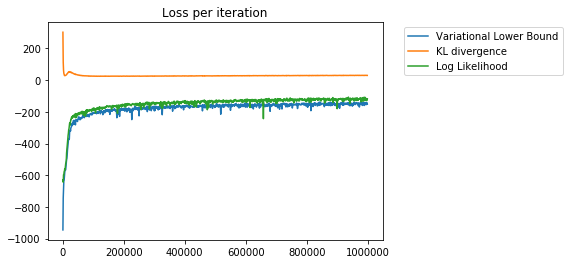

In [14]:

plt.figure()
#for the number of iterations we had 
#plot these 3 terms
plt.plot(iteration_array, variational_lower_bound_array)
plt.plot(iteration_array, KL_term_array)
plt.plot(iteration_array, log_likelihood_array)
plt.legend(['Variational Lower Bound', 'KL divergence', 'Log Likelihood'], bbox_to_anchor=(1.05, 1), loc=2)
plt.title('Loss per iteration')

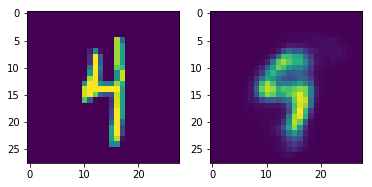

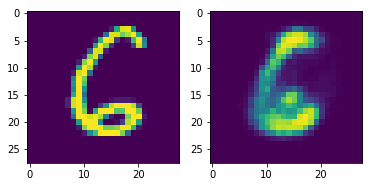

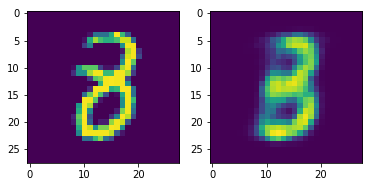

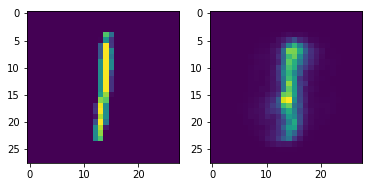

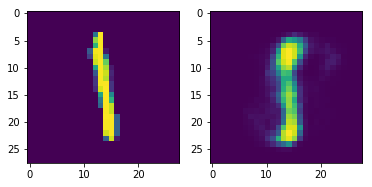

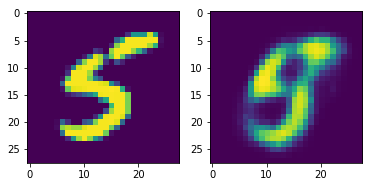

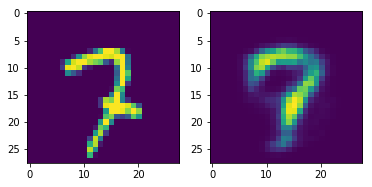

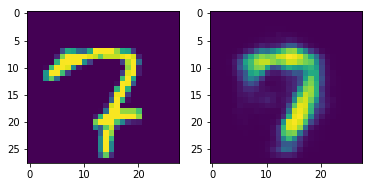

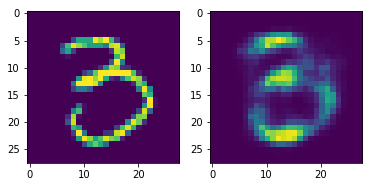

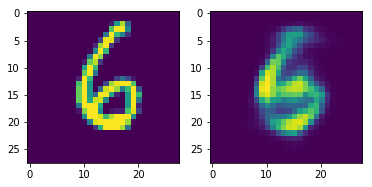

In [15]:

import os
load_model = False
if load_model:
    saver.restore(sess, os.path.join(os.getcwd(), "Trained Bernoulli VAE"))

num_pairs = 10
image_indices = np.random.randint(0, 200, num_pairs)
#Lets plot 10 digits
for pair in range(num_pairs):
    #reshaping to show original test image
    x = np.reshape(mnist.test.images[image_indices[pair]], (1,n_pixels))
    plt.figure()
    x_image = np.reshape(x, (28,28))
    plt.subplot(121)
    plt.imshow(x_image)
    #reconstructed image, feed the test image to the decoder
    x_reconstruction = reconstruction.eval(feed_dict={X: x})
    #reshape it to 28x28 pixels
    x_reconstruction_image = (np.reshape(x_reconstruction, (28,28)))
    #plot it!
    plt.subplot(122)
    plt.imshow(x_reconstruction_image)
